In [1]:
# Dependent variable data preprocessing

import pandas as pd

df = pd.read_csv('raw_datasets/main_dataset/forecasts_and_truth.csv', low_memory=False)
filtered_df = df[df['target_variable'] == 'inc case']
filtered_df = filtered_df[filtered_df['abbreviation'] != 'US']
filtered_df = filtered_df.drop_duplicates(subset=['target_end_date', 'abbreviation'], keep='first')
result_df = filtered_df[['target_end_date', 'abbreviation', 'truth_value']]
result_df.rename(columns={'abbreviation': 'location_key', 'truth_value': 'inc cases'}, inplace=True)
result_df['location_key'] = 'US_' + result_df['location_key']
result_df.to_csv('week5_data/filtered_main_dataset.csv', index=False)

C:\Users\kalei\AppData\Local\Temp\ipykernel_28088\601584150.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result_df.rename(columns={'abbreviation': 'location_key', 'truth_value': 'inc cases'}, inplace=True)
C:\Users\kalei\AppData\Local\Temp\ipykernel_28088\601584150.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result_df['location_key'] = 'US_' + result_df['location_key']


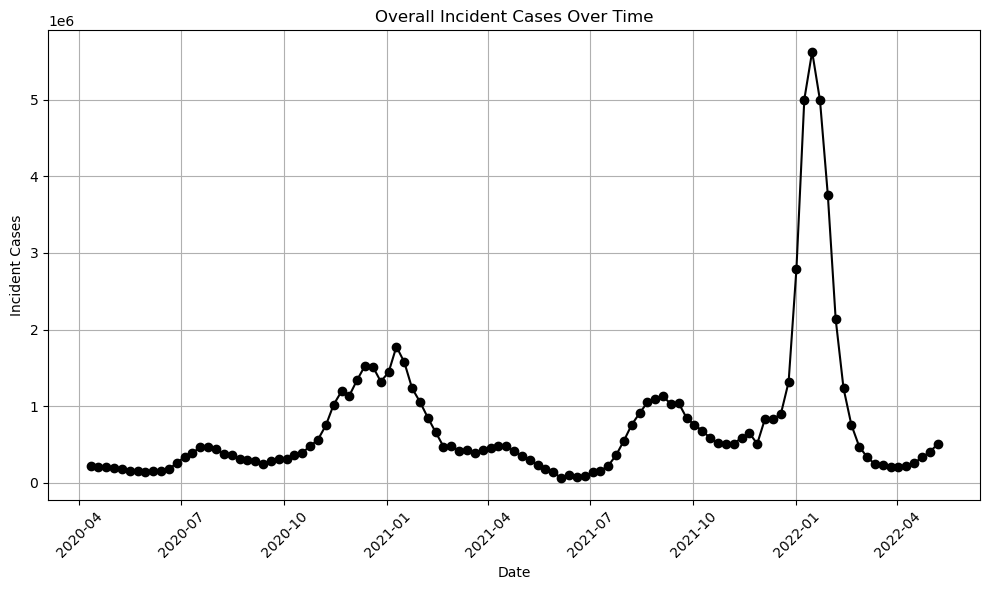

In [2]:
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.dates import AutoDateLocator, AutoDateFormatter

main_csv_path = 'week5_data/filtered_main_dataset.csv'
df = pd.read_csv(main_csv_path, low_memory=False)

df['target_end_date'] = pd.to_datetime(df['target_end_date'])

overall_df = df.groupby('target_end_date')['inc cases'].sum().reset_index()

plt.figure(figsize=(10, 6))
plt.plot(overall_df['target_end_date'], overall_df['inc cases'], color='black', marker='o', linestyle='-')

date_locator = AutoDateLocator()
date_formatter = AutoDateFormatter(date_locator)
plt.gca().xaxis.set_major_locator(date_locator)
plt.gca().xaxis.set_major_formatter(date_formatter)

plt.title('Overall Incident Cases Over Time')
plt.xlabel('Date')
plt.ylabel('Incident Cases')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [3]:
# Independent variable data preprocessing

import pandas as pd
import os

main_csv_path = 'week5_data/filtered_main_dataset.csv'
csv_folder_path = 'raw_datasets/supplementary_dataset_TS'

main_df = pd.read_csv(main_csv_path, low_memory=False)
main_df['target_end_date'] = pd.to_datetime(main_df['target_end_date'])

columns_to_sum = ['new_hospitalized_patients', 'new_persons_fully_vaccinated']
columns_to_average = ['stringency_index', 
                      'average_temperature_celsius', 
                      'search_trends_common_cold']

final_aggregated_data = None  # Start with None for easier checking later

location_keys = set(main_df['location_key'])

for file in os.listdir(csv_folder_path):
    if file.endswith(".csv"):
        file_path = os.path.join(csv_folder_path, file)
        daily_df = pd.read_csv(file_path, low_memory=False)
        daily_df['date'] = pd.to_datetime(daily_df['date'], format="%Y-%m-%d", errors='coerce')
        daily_df = daily_df[daily_df['location_key'].isin(location_keys) & daily_df['date'].notna()]

        # Filter columns available for sum and average to prevent KeyError
        available_columns_to_sum = [col for col in columns_to_sum if col in daily_df.columns]
        available_columns_to_average = [col for col in columns_to_average if col in daily_df.columns]

        if available_columns_to_sum or available_columns_to_average:
            # Group by 'location_key' and 'week_end_date', and perform necessary aggregations
            grouped = daily_df.groupby(['location_key', daily_df['date'].dt.to_period('W-SAT').dt.to_timestamp('W-SAT')])
            aggregated = grouped.agg({**{col: 'sum' for col in available_columns_to_sum},
                                      **{col: 'mean' for col in available_columns_to_average}}).reset_index().rename(columns={'date': 'week_end_date'})

            # Merge this file's aggregated data into the final DataFrame
            if final_aggregated_data is None:
                final_aggregated_data = aggregated
            else:
                final_aggregated_data = pd.merge(final_aggregated_data, aggregated, on=['week_end_date', 'location_key'], how='outer', suffixes=('', '_dup'))

                # Handle any duplicate columns if they exist by averaging sum and mean columns, if required
                for col in set(available_columns_to_sum + available_columns_to_average):
                    if f'{col}_dup' in final_aggregated_data:
                        final_aggregated_data[col] = final_aggregated_data[[col, f'{col}_dup']].mean(axis=1)
                        final_aggregated_data.drop(columns=[f'{col}_dup'], inplace=True)

# Sort the final aggregated data by 'week_end_date'
final_aggregated_data = final_aggregated_data.sort_values(by='week_end_date')

# Filter final_aggregated_data to only include target_end_dates present in the main_df
final_aggregated_data = final_aggregated_data[final_aggregated_data['week_end_date'].isin(main_df['target_end_date'])]

# Ensure 'week_end_date' is the first column
col_order = ['week_end_date'] + [col for col in final_aggregated_data.columns if col != 'week_end_date']
final_aggregated_data = final_aggregated_data[col_order]

final_aggregated_data.rename(columns={'week_end_date': 'target_end_date'}, inplace=True)

final_aggregated_data = pd.merge(final_aggregated_data, main_df, on=['target_end_date', 'location_key'], how='outer', suffixes=('', '_dup'))

# Save the filtered and reordered aggregated data to a CSV file
output_path = 'week5_data/weekly_aggregated_sup_data.csv'
final_aggregated_data.to_csv(output_path, index=False)

print(f"Filtered and ordered aggregated data saved to {output_path}")

Filtered and ordered aggregated data saved to week5_data/weekly_aggregated_sup_data.csv


In [25]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.dates import AutoDateLocator, AutoDateFormatter

df = pd.read_csv('processed_data/weekly_data_unemployment.csv')

df['log_inc_cases'] = np.log(df['inc cases'] + 1)
df['log_new_hospitalized_patients'] = np.log(df['new_hospitalized_patients'] + 1)
df['log_new_persons_fully_vaccinated'] = np.log(df['new_persons_fully_vaccinated'] + 1)

df.to_csv('week5_data/log_weekly_aggregated_unemployment_data.csv', index=False)

c:\Users\celia\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\celia\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\celia\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\celia\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [26]:
# Missing data percentage calculation

import pandas as pd
import numpy as np

results_df = pd.read_csv('processed_data/weekly_data_unemployment.csv')

missing_value_percentages = results_df.select_dtypes(include=[np.number]).isnull().mean().sort_values() * 100

print(missing_value_percentages)

average_temperature_celsius      0.000000
inc cases                        1.245085
new_hospitalized_patients        2.342726
search_trends_common_cold        8.928571
stringency_index                 8.928571
unemployment_rate               10.714286
new_persons_fully_vaccinated    36.697248
dtype: float64


In [27]:
# Main dataset regression (without deduce 0 variance variables)

import pandas as pd
import statsmodels.api as sm

# Load the dataset
final_dataset = pd.read_csv('processed_data/weekly_data_unemployment.csv')

# Define the dependent variable
Y = final_dataset['inc cases']

# Create dummy variables for 'location_key' before defining X and y
final_dataset = pd.get_dummies(final_dataset, columns=['location_key'], drop_first=True, dtype=float)

# List of selected variables (assumed after location_key dummies are created)
selected_variables = [
    'new_hospitalized_patients', 
    'new_persons_fully_vaccinated',
    'stringency_index', 
    'average_temperature_celsius', 
    'search_trends_common_cold', 
    'unemployment_rate'
] + [col for col in final_dataset.columns if 'location_key_' in col]  # This includes all dummy variables for location_key

# Fill missing values for the selected numerical columns
for column in selected_variables:
    if column in final_dataset and final_dataset[column].dtype != 'object':
        final_dataset[column].fillna(final_dataset[column].mean(), inplace=True)
        
# Define X with selected variables including dummy variables
X = final_dataset[selected_variables]

# Adding a constant for the intercept
X = sm.add_constant(X)

# Ensure 'y' is numeric and handle missing values
Y = pd.to_numeric(Y, errors='coerce').fillna(Y.mean())

# Fit the OLS model
model = sm.OLS(Y, X).fit()

# Print the summary
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:              inc cases   R-squared:                       0.706
Model:                            OLS   Adj. R-squared:                  0.703
Method:                 Least Squares   F-statistic:                     237.8
Date:                Fri, 17 May 2024   Prob (F-statistic):               0.00
Time:                        12:56:27   Log-Likelihood:                -68596.
No. Observations:                6104   AIC:                         1.373e+05
Df Residuals:                    6042   BIC:                         1.377e+05
Df Model:                          61                                         
Covariance Type:            nonrobust                                         
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
const           

In [28]:
import numpy as np

predictions = model.predict(X)

# Errors
errors = Y - predictions

# Mean Absolute Error (MAE)
mae = np.mean(np.abs(errors))

# Mean Squared Error (MSE)
mse = np.mean(errors**2)

# Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse)
aic = model.aic

print("IV Mean:", Y.mean())
print("IV Median", Y.median())
print("MAE:", mae)
print("RMSE:", rmse)
print("AIC:", aic)

IV Mean: 13512.52090245521
IV Median 4659.0
MAE: 7312.714118046528
RMSE: 18378.548177946137
AIC: 137316.01385201717


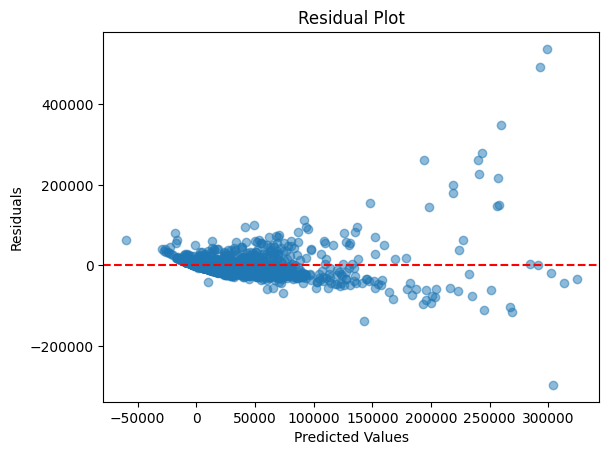

In [29]:
import matplotlib.pyplot as plt

# Residual Plot
plt.scatter(predictions, errors, alpha=0.5)
plt.title('Residual Plot')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.axhline(y=0, color='r', linestyle='--')
plt.show()

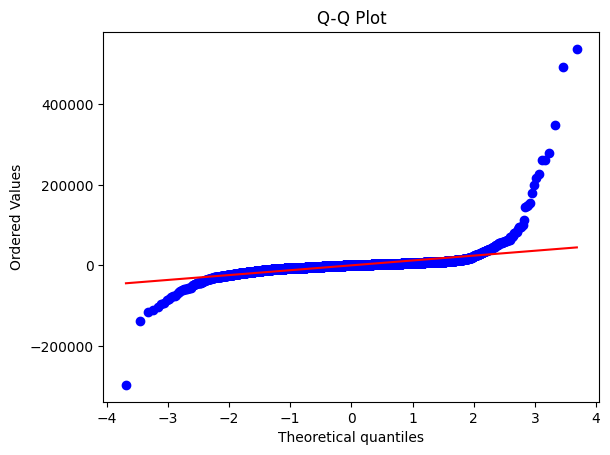

In [30]:
import scipy.stats as stats
import matplotlib.pyplot as plt

# Q-Q plot
stats.probplot(errors, dist="norm", plot=plt)
plt.title('Q-Q Plot')
plt.show()

In [31]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
import pandas as pd

X_vif = X.loc[:, ~X.columns.str.startswith('location_key')]
X_vif = X_vif.drop(columns=['const'], errors='ignore')

# calculate VIF for each feature
def calculate_vifs(X):
    vif_data = pd.DataFrame()
    vif_data["variable"] = X.columns

    vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    
    return vif_data

vif_data = calculate_vifs(X_vif)

# Filter out variables with VIF greater than a threshold (commonly 5 or 10)
print(vif_data[vif_data["VIF"] > 0].sort_values(by="VIF", ascending=False))

                       variable        VIF
2              stringency_index  14.758750
5             unemployment_rate  10.923764
4     search_trends_common_cold   5.069656
3   average_temperature_celsius   2.653450
1  new_persons_fully_vaccinated   1.531916
0     new_hospitalized_patients   1.511491


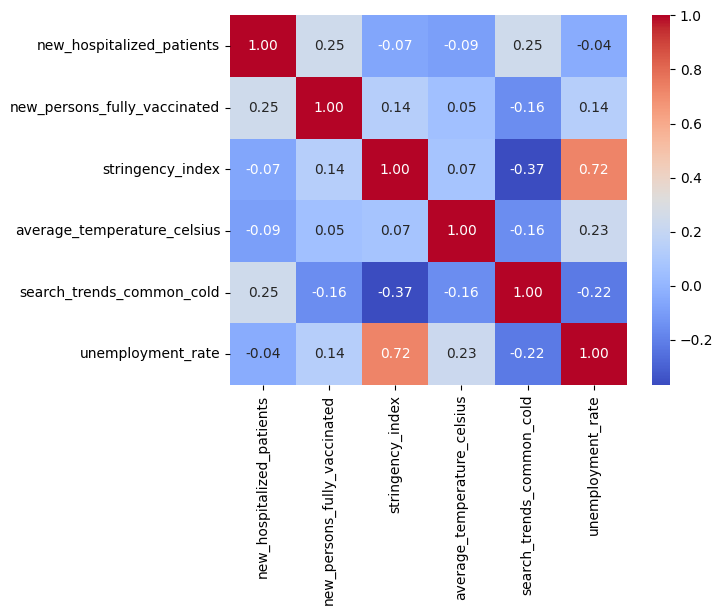

In [32]:
import seaborn as sns
import matplotlib.pyplot as plt

filtered_X = X.loc[:, ~X.columns.str.startswith('location_key')]
filtered_X = filtered_X.loc[:, filtered_X.std() > 0]
corr = filtered_X.corr()

# heatmap
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f")
plt.show()

In [33]:
# Main dataset regression (0 variance variables deduced)

import pandas as pd
import numpy as np
import statsmodels.api as sm
from sklearn.feature_selection import VarianceThreshold
from sklearn.preprocessing import StandardScaler

df = pd.read_csv('processed_data/weekly_data_unemployment.csv', low_memory=False)

# Select predictors and target variable before dropping missing values
X = df[[
    'inc cases',
    'location_key',
    'new_hospitalized_patients', 
    'new_persons_fully_vaccinated',
    'stringency_index', 
    'average_temperature_celsius', 
    'search_trends_common_cold', 
    'unemployment_rate']]

# Drop rows with missing values in any selected variable or the target
data_cleaned = X.dropna(axis=0, how='any')

# Separate predictors and target variable after cleaning
y_cleaned = data_cleaned['inc cases']
X_cleaned = data_cleaned.drop(columns=['inc cases'])

# One-hot encoding categorical variables and dropping the first dummy to avoid multicollinearity
X_encoded = pd.get_dummies(X_cleaned, columns=['location_key'], drop_first=True).astype(int)

# Drop variables with 0 variability (no information) or high correlation (multicollinearity)

# VarianceThreshold with a threshold of 0 (default) to remove 0 variance columns
selector = VarianceThreshold()
X_encoded_var_filtered = selector.fit_transform(X_encoded)
# Get the columns after variance thresholding
X_encoded_var_filtered = X_encoded.iloc[:, selector.get_support(indices=True)]

# Calculate the correlation matrix (absolute value - we don't care about direction of correlation)
corr_matrix = X_encoded_var_filtered.corr().abs()

# Select upper triangle of correlation matrix
upper_tri = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

# Initialize an empty list to keep track of columns to drop
to_drop = []

# Iterate over the columns of the upper triangle
for column in upper_tri.columns:
    for row in upper_tri.index:
        # Check if the correlation is above the threshold and the column hasn't been considered yet
        if upper_tri.loc[row, column] > 0.9 and column not in to_drop and row not in to_drop:
            to_drop.append(column)
            break  # Break the loop once a column is marked for dropping

# 'to_drop' contains columns where only one of each highly correlated pair is considered for dropping

# Drop highly correlated features 
X_encoded_final = X_encoded_var_filtered.drop(columns=to_drop)

# Standardise features to help with interpretation 

# Initialize the StandardScaler
scaler = StandardScaler()

# Fit on training set only
scaler.fit(X_encoded_final)

# Apply transform to both the training set and the test set
X_train_scaled = pd.DataFrame(scaler.transform(X_encoded_final), columns=X_encoded_final.columns, index=X_encoded_final.index)

# Adding a constant for the intercept
X_encoded_with_const = sm.add_constant(X_train_scaled)

from IPython.core.display import display, HTML

display(HTML("<style>.container { width:90% !important; }</style>"))

# Fitting the linear regression model
model = sm.OLS(y_cleaned, X_encoded_with_const ).fit()

# Displaying the regression results
print(model.summary())

C:\Users\celia\AppData\Local\Temp\ipykernel_23768\847716954.py:76: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


                            OLS Regression Results                            
Dep. Variable:              inc cases   R-squared:                       0.739
Model:                            OLS   Adj. R-squared:                  0.735
Method:                 Least Squares   F-statistic:                     174.6
Date:                Fri, 17 May 2024   Prob (F-statistic):               0.00
Time:                        12:56:34   Log-Likelihood:                -39282.
No. Observations:                3450   AIC:                         7.868e+04
Df Residuals:                    3394   BIC:                         7.902e+04
Df Model:                          55                                         
Covariance Type:            nonrobust                                         
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
const           

In [34]:
import numpy as np

predictions = model.predict(X_encoded_with_const)

# Errors
errors = y_cleaned - predictions

# Mean Absolute Error (MAE)
mae = np.mean(np.abs(errors))

# Mean Squared Error (MSE)
mse = np.mean(errors**2)

# Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse)

aic = model.aic

print("IV Mean:", y_cleaned.mean())
print("IV Median", y_cleaned.median())
print("MAE:", mae)
print("RMSE:", rmse)
print("AIC:", aic)

IV Mean: 17059.660869565218
IV Median 5995.0
MAE: 9272.148082571643
RMSE: 21312.779894257565
AIC: 78675.40483008763


Log transformation model

In [35]:
import pandas as pd
import numpy as np
import statsmodels.api as sm

# Load the dataset
final_dataset = pd.read_csv('processed_data/weekly_data_unemployment.csv').drop(columns=['target_end_date'])

# Apply log transformation to the dependent variable and selected independent variables
# Ensure to add 1 to avoid log(0)
final_dataset['log_inc_cases'] = np.log(final_dataset['inc cases'] + 1)
final_dataset['log_new_hospitalized_patients'] = np.log(final_dataset['new_hospitalized_patients'] + 1)
final_dataset['log_new_persons_fully_vaccinated'] = np.log(final_dataset['new_persons_fully_vaccinated'] + 1)
final_dataset['log_unemployment_rate'] = np.log(final_dataset['unemployment_rate'] + 1)

# Update the dataset with dummy variables for 'location_key'
final_dataset = pd.get_dummies(final_dataset, columns=['location_key'], drop_first=True, dtype=float)

# Updated list of selected variables including the log-transformed variables
selected_variables_transformed = [
    'log_new_hospitalized_patients', 
    # 'log_new_persons_fully_vaccinated',
    'stringency_index', 
    'average_temperature_celsius', 
    'search_trends_common_cold',
    'unemployment_rate'
] + [col for col in final_dataset.columns if 'location_key_' in col]

# Fill missing values for numerical columns
final_dataset[selected_variables_transformed] = final_dataset[selected_variables_transformed].fillna(final_dataset[selected_variables_transformed].mean())

display(final_dataset)

# Handling infinite values possibly introduced by log transformation
final_dataset.replace([np.inf, -np.inf], np.nan, inplace=True)
final_dataset.fillna(final_dataset.mean(), inplace=True)

# Define the dependent and independent variables
X = final_dataset[selected_variables_transformed]
Y = final_dataset['log_inc_cases']

# Adding a constant for the intercept
X = sm.add_constant(X)

# Fit the OLS model
model = sm.OLS(Y, X).fit()

# Print the summary
print(model.summary())

c:\Users\celia\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\celia\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\celia\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\celia\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


,search_trends_common_cold,new_hospitalized_patients,stringency_index,new_persons_fully_vaccinated,average_temperature_celsius,inc cases,unemployment_rate,log_inc_cases,log_new_hospitalized_patients,log_new_persons_fully_vaccinated,...,location_key_US_TN,location_key_US_TX,location_key_US_UT,location_key_US_VA,location_key_US_VI,location_key_US_VT,location_key_US_WA,location_key_US_WI,location_key_US_WV,location_key_US_WY
0,14.744286,0.0,79.630000,NaN,10.089947,2728.0,16.700000,7.911691,0.000000,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,16.530000,326.0,64.418571,NaN,14.730159,1374.0,13.800000,7.226209,5.789960,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,16.725714,66.0,87.960000,NaN,6.176367,362.0,11.800000,5.894403,4.204693,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,17.327143,0.0,82.410000,NaN,8.069665,1543.0,17.900000,7.342132,0.000000,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,17.478571,0.0,78.700000,NaN,9.071429,6234.0,8.300000,8.737934,0.000000,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6099,10.401429,758.0,33.330000,10881.0,11.180952,22726.0,3.700000,10.031309,6.632002,9.294865,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6100,9.471429,68.0,31.480000,24442.0,15.046826,0.0,5.841596,0.000000,4.234107,10.104099,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6101,9.917143,359.0,27.780000,5160.0,9.521958,11418.0,2.300000,9.343034,5.886104,8.548886,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6102,9.102857,117.0,30.951429,1287.0,15.607936,1726.0,3.800000,7.454141,4.770685,7.160846,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


                            OLS Regression Results                            
Dep. Variable:          log_inc_cases   R-squared:                       0.780
Model:                            OLS   Adj. R-squared:                  0.778
Method:                 Least Squares   F-statistic:                     357.5
Date:                Fri, 17 May 2024   Prob (F-statistic):               0.00
Time:                        12:56:45   Log-Likelihood:                -8247.0
No. Observations:                6104   AIC:                         1.662e+04
Df Residuals:                    6043   BIC:                         1.703e+04
Df Model:                          60                                         
Covariance Type:            nonrobust                                         
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
const         

In [36]:
import numpy as np

predictions = model.predict(X)

# Errors
errors = Y - predictions

# Mean Absolute Error (MAE)
mae = np.mean(np.abs(errors))

# Mean Squared Error (MSE)
mse = np.mean(errors**2)

# Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse)
aic = model.aic

print("IV Log mean:", Y.mean())
print("IV Log median", Y.median())
print("MAE:", mae)
print("RMSE:", rmse)
print("AIC:", aic)

IV Log mean: 8.154094153618914
IV Log median 8.399647115226195
MAE: 0.6464900463088158
RMSE: 0.9343925341015756
AIC: 16615.983128883687


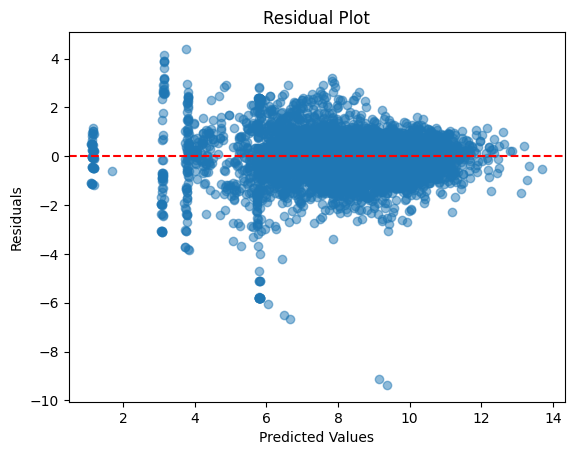

In [37]:
import matplotlib.pyplot as plt

# Residual Plot
plt.scatter(predictions, errors, alpha=0.5)
plt.title('Residual Plot')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.axhline(y=0, color='r', linestyle='--')
plt.show()

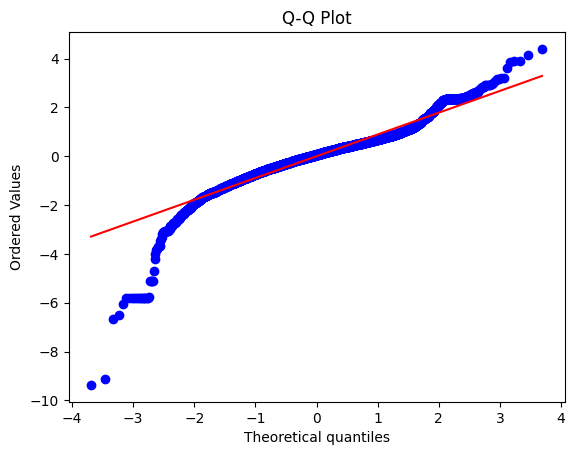

In [38]:
import scipy.stats as stats
import matplotlib.pyplot as plt

# Q-Q plot
stats.probplot(errors, dist="norm", plot=plt)
plt.title('Q-Q Plot')
plt.show()

In [39]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
import pandas as pd

X_vif = X.loc[:, ~X.columns.str.startswith('location_key')]
X_vif = X_vif.drop(columns=['const'], errors='ignore')

# calculate VIF for each feature
def calculate_vifs(X):
    vif_data = pd.DataFrame()
    vif_data["variable"] = X.columns

    vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    
    return vif_data

vif_data = calculate_vifs(X_vif)

# Filter out variables with VIF greater than a threshold (commonly 5 or 10)
print(vif_data[vif_data["VIF"] > 0].sort_values(by="VIF", ascending=False))

                        variable        VIF
1               stringency_index  16.238376
4              unemployment_rate  11.355868
3      search_trends_common_cold   7.327038
0  log_new_hospitalized_patients   6.383412
2    average_temperature_celsius   2.623468


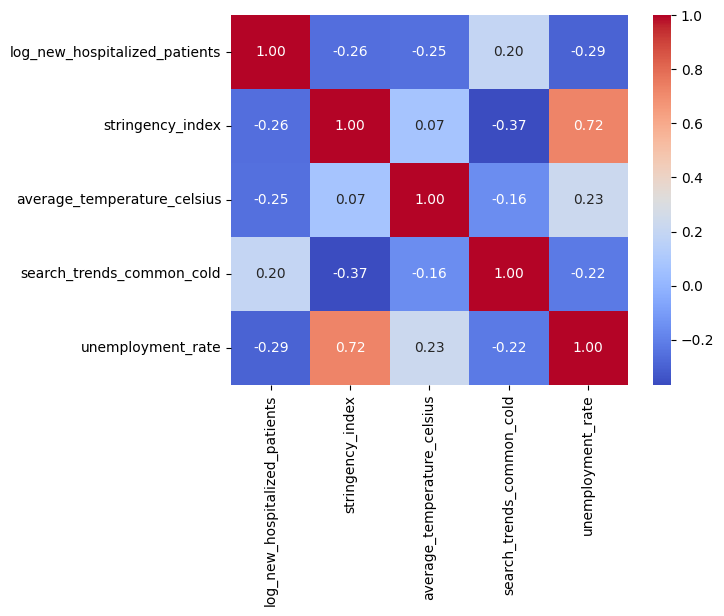

In [40]:
import seaborn as sns
import matplotlib.pyplot as plt

filtered_X = X.loc[:, ~X.columns.str.startswith('location_key')]
filtered_X = filtered_X.loc[:, filtered_X.std() > 0]
corr = filtered_X.corr()

# heatmap
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f")
plt.show()

In [43]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import pandas as pd
import numpy as np

final_dataset = pd.read_csv('processed_data/weekly_data_unemployment.csv')

selected_variables = [
    'new_hospitalized_patients', 
    'new_persons_fully_vaccinated',
    'stringency_index', 
    'average_temperature_celsius', 
    'search_trends_common_cold',
    'unemployment_rate'
]

# Define X and y from the final_dataset
X = final_dataset[selected_variables]
Y = final_dataset['inc cases'].astype(float).fillna(final_dataset['inc cases'].mean())

# Handle NA values by filling them with the mean of their respective column
X = X.apply(lambda col: col.fillna(col.mean()), axis=0)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

# Initialize the Random Forest model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)

# Train the model
rf_model.fit(X_train, y_train)

# Make predictions on the test set
predictions = rf_model.predict(X_test)

# Calculate RMSE and R^2 for the test set
rmse = np.sqrt(mean_squared_error(y_test, predictions))
r2 = r2_score(y_test, predictions)

print(f"Test RMSE: {rmse}")
print(f"Test R^2 Score: {r2}")

# Feature Importances
feature_importances = rf_model.feature_importances_
importances_df = pd.DataFrame({'feature': X_train.columns, 'importance': feature_importances})
importances_df.sort_values(by='importance', ascending=False, inplace=True)

print(importances_df)

Test RMSE: 9489.310320250122
Test R^2 Score: 0.8871179533657967
                        feature  importance
0     new_hospitalized_patients    0.708413
4     search_trends_common_cold    0.135742
3   average_temperature_celsius    0.064705
1  new_persons_fully_vaccinated    0.043000
2              stringency_index    0.029142
5             unemployment_rate    0.018997


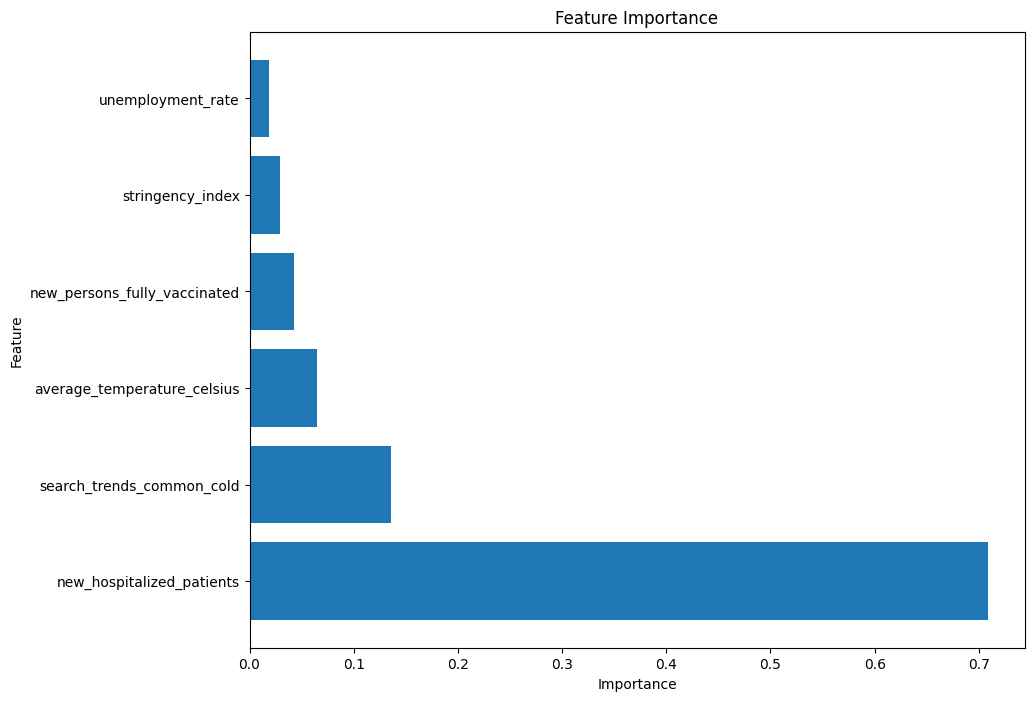

In [44]:
import matplotlib.pyplot as plt

# Plot the feature importances
plt.figure(figsize=(10, 8))
plt.barh(importances_df['feature'], importances_df['importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance')
plt.show()